In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# CONSTANTS

THETA   = 1/2
KAPPA   = 1/2
OMEGA_A = 0.1
OMEGA_U = 0.1
GAMMA_U = 0.9
BETA_U  = 0.1 # BETA_Y IN ASSIGMENT !
BETA_A  = 0.1 # MISSING IN ASSIGMENT ! 
SIGMA_D = 1
LAMBDA  = 1

In [3]:
# DEFINE THE MATRICES

A = np.array([
        [1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1],
        [0, 0, 0, THETA, THETA - KAPPA],
        [0, 0, 0, 1 - OMEGA_A, 0],
        [0, 0, 0, 0, 1 - OMEGA_U]])
B = np.array([1, GAMMA_U, (THETA - KAPPA) * GAMMA_U, 0, OMEGA_U * BETA_U])

Sigma_x = np.array([
    [0, 0, 0, 0, 0], 
    [0, SIGMA_D**2, THETA*SIGMA_D**2, 0, 0],
    [0, THETA*SIGMA_D**2, THETA**2*SIGMA_D**2, 0, 0],
    [0, 0, 0, BETA_A**2, 0],
    [0, 0, 0, 0, 0]])

Q = np.array([
    [LAMBDA*SIGMA_D**2, 0, 0, -1, -1], 
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]])


S = np.array([
    [LAMBDA*THETA*SIGMA_D**2 - GAMMA_U/2, 0, 0, -THETA/2, -(THETA - KAPPA)/2]])


R = np.array([[LAMBDA - (THETA - KAPPA)*GAMMA_U]])


In [4]:
# DEFINE THE POLICIES

def policy_a(x, g):
    """ x: (N, nStep, 5)
        g: (N, nStep, 1)
    """

    return np.zeros_like(g)

def policy_b(x, g):
    """ x: (N, nStep, 5)
        g: (N, nStep, 1)
    """
    return np.sign(g)

def policy_c(x, g):
    """ x: (N, nStep, 5)
        g: (N, nStep, 1)
    """
    # TO DO 
    return np.sign(g)


In [77]:
def compute_trajectory(x0 : np.ndarray, N: int, nStep: int, policy: callable, A : np.ndarray, B : np.ndarray, Sigma_x : np.ndarray):
    """
    Compute N trajectories of the stochastic state-space model and compute the reward, i.e., 

                        xt+1 = Axt + But + wt+1, wt+1 ~ N(0, Sigma_x) 
                        gt = I_{t} * x^e_{t+1} + u_{t} * x^e_{t+1}

                    
    Parameters
    ----------
    x0 : np.ndarray
        Initial state.
    N : int
        # of trajectory.
    M : int
        # of particles for the conditional expectation.
    nStep : int
        # of time steps.
    policy : callable
        Policy function.
    A : np.ndarray
        System matrix.
    B : np.ndarray
        Control matrix.
    Sigma_x : np.ndarray
        Covariance matrix of the state noise.

    Returns
    -------

    x : np.ndarray
        State trajectory.
    u : np.ndarray
        Control trajectory.
    g : np.ndarray
        Reward trajectory.    
    """


    x = np.zeros((N, nStep+1, 5))
    u = np.zeros((N, nStep+1,))
    g =  np.zeros((N, nStep+1,))

    x[:, 0] = x0
    

    for t in range(nStep) :

        noise = np.random.multivariate_normal(np.zeros(5), Sigma_x, N) # (N, 5)

        u[:, t] = policy(x[:, t-1], g[:, t-1]) if t > 0 else policy(x[:, 0], g[:, 0])
        x[:, t+1] = np.einsum("kl, nl -> nk", A,  x[:, t]) + B  * u[:, t, np.newaxis] + noise
        g[:, t] = x[:, t, 0]*x[:, t+1, 1] + u[:, t]*x[:, t+1, 2] 

    return x[:, :nStep, :], u[:, :nStep], g[:, :nStep]


def monte_carlo_simulation(x : np.ndarray, u : np.ndarray, M : int, policy: callable, A : np.ndarray, B : np.ndarray, Sigma_x : np.ndarray):
    """
    Compute the Monte Carlo approximations : 
        * E[g_t | x_t, x_{t-1}, ..., x_0]
        * var[g_t | x_t, x_{t-1}, ..., x_0]
        * E[(x_t u_t) L (x_t u_t)^T | x_t, x_{t-1}, ..., x_0] (with L = [[Q S], [S^T R]])

    and finally compute the LQR cost with the above approximations.
    
    For the N given trajectories (x, u), we compute the conditional expectation and variance of the reward g_t by performing M monte-carlo simulation
    at each time step and for each trajectories.
                    
    Parameters
    ----------
    x : np.ndarray
        State trajectories.
    u : np.ndarray
        Control trajectories.
    M : int
        # of particles for the conditional expectation.
    policy : callable
        Policy function.
    A : np.ndarray
        System matrix.
    B : np.ndarray
        Control matrix.
    Sigma_x : np.ndarray
        Covariance matrix of the state noise.

    Returns
    -------

    X : np.ndarray
        State trajectory with the M additional Monte-Carlo simulation.
    
    E_g : np.ndarray
        E[g_t | x_t, x_{t-1}, ..., x_0]    
    V_g : np.ndarray
        var[g_t | x_t, x_{t-1}, ..., x_0]

    LQR1 : np.ndarray    
        LQR cost with first method.
    
    LQR2 : np.ndarray
        LQR cost with second method.
    """

    N, nStep, _ = x.shape    
    X = np.zeros((N, M, nStep+1, 5)) 
    G = np.zeros((N, M, nStep,))

    X[..., 0, :] = x[:, np.newaxis, 0, :]

    for t in range(nStep):
        
        noise = np.random.multivariate_normal(np.zeros(5), Sigma_x, (N, M)) # (N, M, 5)
        delta_x = np.einsum("kl, nl -> nk", A,  x[:, t]) + B  * u[:, t, np.newaxis] # (N, 5)

        X[..., t+1, :] =  delta_x[:, np.newaxis, :] + noise # (N, M, 5)
        G[..., t] = x[:, np.newaxis, t, 0]*X[..., t+1, 1] + u[:,t, np.newaxis]*X[..., t+1, 2]


    #============Method 1=============#

    E_g = np.mean(G, axis=1) # (N, nStep)
    V_g = np.var(G, axis=1) # (N, nStep)

    LQR1_t = np.mean(LAMBDA*V_g - E_g, axis = 0)
    LQR1 = np.mean(LQR1_t)

    #============Method 2=============#

    L = np.block([[Q, S.T], [S, R]])
    u_expended = np.tile(u[:, np.newaxis, :, np.newaxis], (1, M, 1, 1)) # (N, M, nStep, 1)
    v = np.concatenate((X[..., :nStep, :], u_expended), axis=-1) # (N, M, nStep, 6)
    
    LQR2_t = np.mean(np.einsum("nmtk, nmtk -> nmt", v, np.einsum("kl, nmtl -> nmtk", L, v)), axis=1)
    LQR2 = np.mean(np.mean(LQR2_t, axis=0))

    return X[..., :nStep, :], E_g, V_g, LQR1, LQR2

In [102]:
x0 = np.array([5, 0, 0, 0, 0])
N = 1000
M = 500
nStep = 200
policy = policy_b

x, u, g = compute_trajectory(x0, N, nStep, policy, A, B, Sigma_x)
X, E_g, V_g, LQR1, LQR2 = monte_carlo_simulation(x, u, M, policy, A, B, Sigma_x)


print("Method 1 : cost = ", LQR1)
print("Method 2 : cost = ", LQR2)


Method 1 : cost =  226.68712608781468
Method 2 : cost =  227.89318881704466


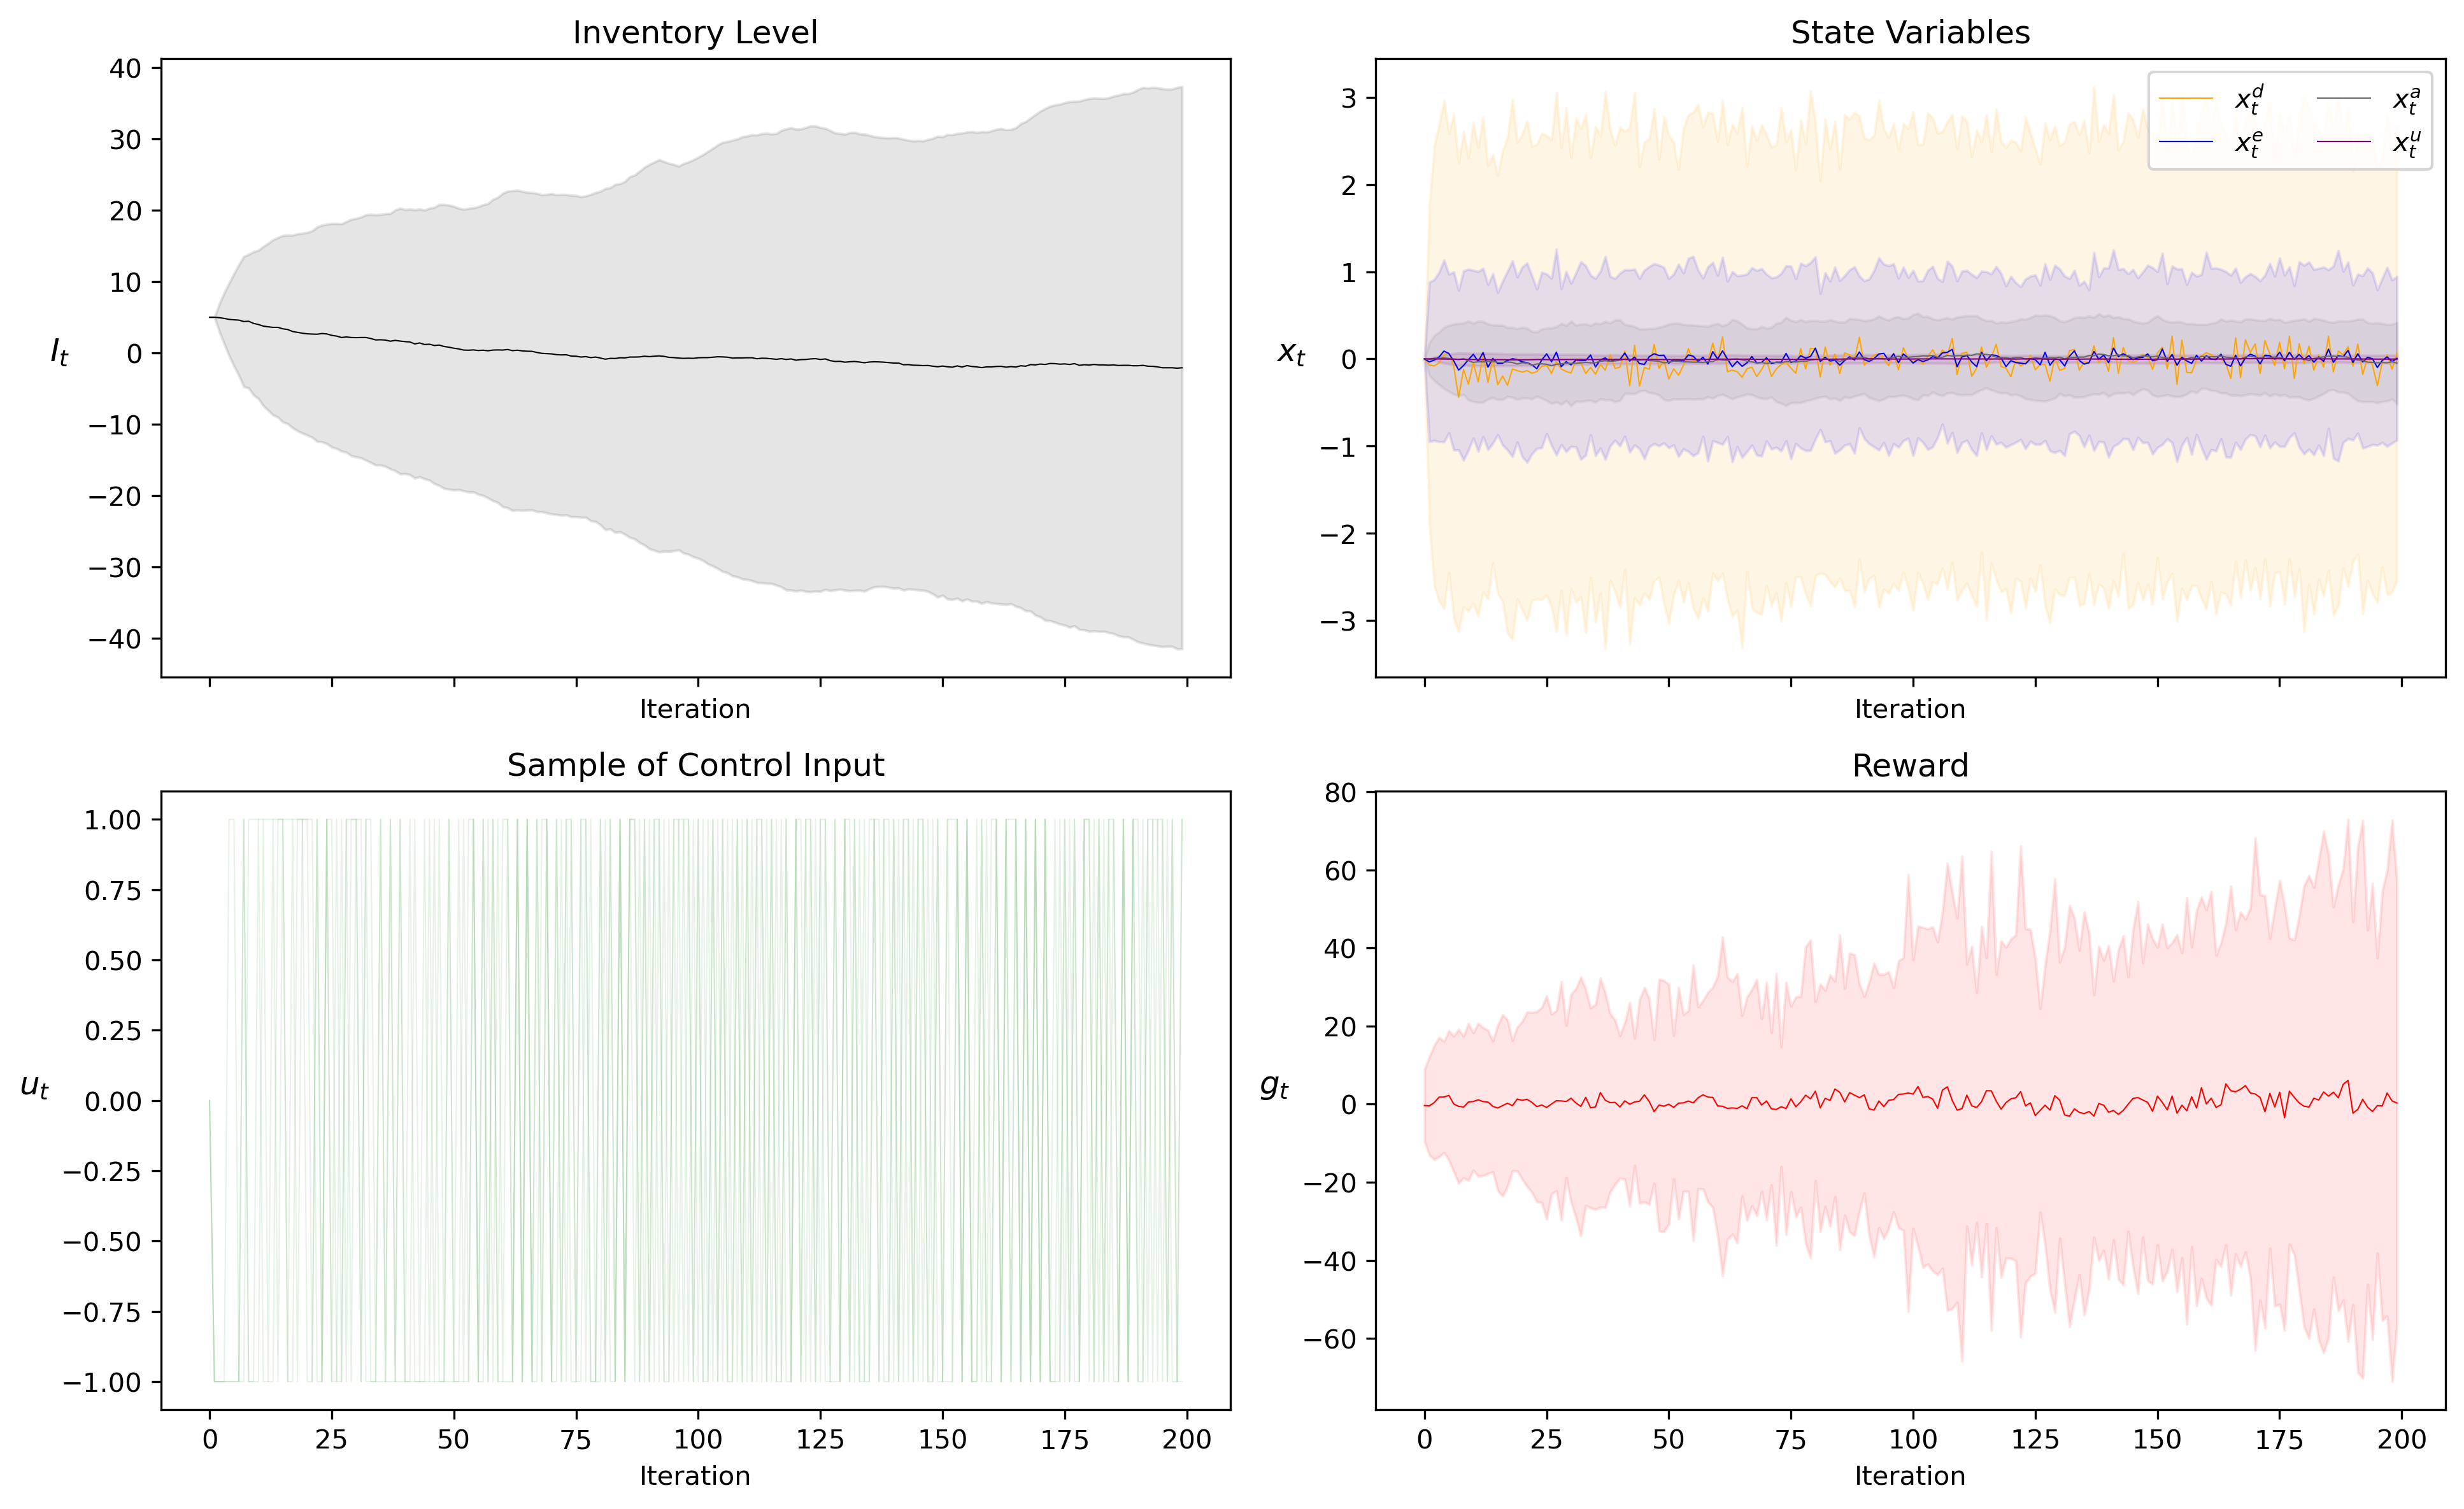

In [101]:
fig, axs = plt.subplots(2, 2, figsize=(13, 8), dpi = 300, sharex = True)
ax1, ax2, ax3, ax4 = axs.flatten()
# left top plot

mean = np.mean(x[:, :, 0], axis = 0)
var = np.var(x[:, :, 0], axis = 0)
ci_lower = mean - 1.96 * np.sqrt(var)
ci_upper = mean + 1.96 * np.sqrt(var)

ax1.plot(mean, color = "k", linewidth = 0.5)
ax1.fill_between(np.arange(nStep), ci_lower, ci_upper, color='k', alpha=0.1)
ax1.set_title("Inventory Level")
ax1.set_xlabel("Iteration")
ax1.set_ylabel(r"$I_t$", rotation=0, labelpad=10, fontsize=12)



# right top plot

means = [np.mean(x[:, :, i], axis = 0) for i in range(1, 5)]
vars  = [np.var(x[:, :, i], axis = 0) for i in range(1, 5)]
colors = ["orange", "blue", "dimgray", "purple"]
names = ["$x^d_t$", "$x^e_t$", "$x^a_t$", "$x^u_t$"]

for i, (mean, var) in enumerate(zip(means, vars)) :
    ci_lower = mean - 1.96 * np.sqrt(var)
    ci_upper = mean + 1.96 * np.sqrt(var)
    ax2.plot(mean, color = colors[i], linewidth = 0.5, label = names[i])
    ax2.fill_between(np.arange(nStep), ci_lower, ci_upper, color=colors[i], alpha=0.1)
    ax2.set_title("State Variables")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel(r"$x_t$", rotation=0, labelpad=10, fontsize=12)

ax2.legend(ncol = 2)


# left bottom plot

n_Sample = 3

ax3.plot(u[:n_Sample,:].T, alpha=0.1, color='green', linewidth = 0.5)
# ax3.fill_between(np.arange(nStep), ci_lower, ci_upper, color='green', alpha=0.1)
ax3.set_title('Sample of Control Input')
ax3.set_xlabel('Iteration')
ax3.set_ylabel(r"$u_t$", rotation=0, labelpad=10, fontsize=12)



# right bottom plot
mean = np.mean(g, axis = 0)
var = np.var(g, axis = 0)
ci_lower = mean - 1.96 * np.sqrt(var)
ci_upper = mean + 1.96 * np.sqrt(var)

ax4.plot(mean, color='r', linewidth = 0.5)
ax4.fill_between(np.arange(nStep), ci_lower, ci_upper, color='r', alpha=0.1)
ax4.set_title('Reward')
ax4.set_xlabel('Iteration')
ax4.set_ylabel(r"$g_t$", rotation=0, labelpad=10, fontsize=12)

plt.tight_layout()  
plt.show()


